In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import utility_functions as fn

## Initialization

In [2]:
# read from csv into a new dataframe
raw_weather = pd.read_csv('../data/weather_raw2.csv',index_col=1)

# reindex by appropriate datetime
raw_weather.index = pd.to_datetime(raw_weather.index,format='%Y-%m-%d %H:00:00 +0000 UTC')
raw_weather.index.names = ['']

# remove unused columns
unused = raw_weather.columns[np.array([0,1,2,3,4,9,10,13,15,16,17,19,20,21,23,24,25,26])]
raw_weather.drop(unused,axis=1,inplace=True)

# rename and reorder columns
column_names = ['temp','tmin','tmax','pressure','rh','wind','rain','snow','clouds']
raw_weather.columns = column_names
raw_weather = raw_weather[['temp','tmin','tmax','pressure','rh','wind','clouds','rain','snow']]

In [3]:
# drop duplicate rows
raw_weather.drop_duplicates(inplace=True)

# reindex to add missing rows, for a total length of 53545
correct_dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')
raw_weather = raw_weather.reindex(index=correct_dt)

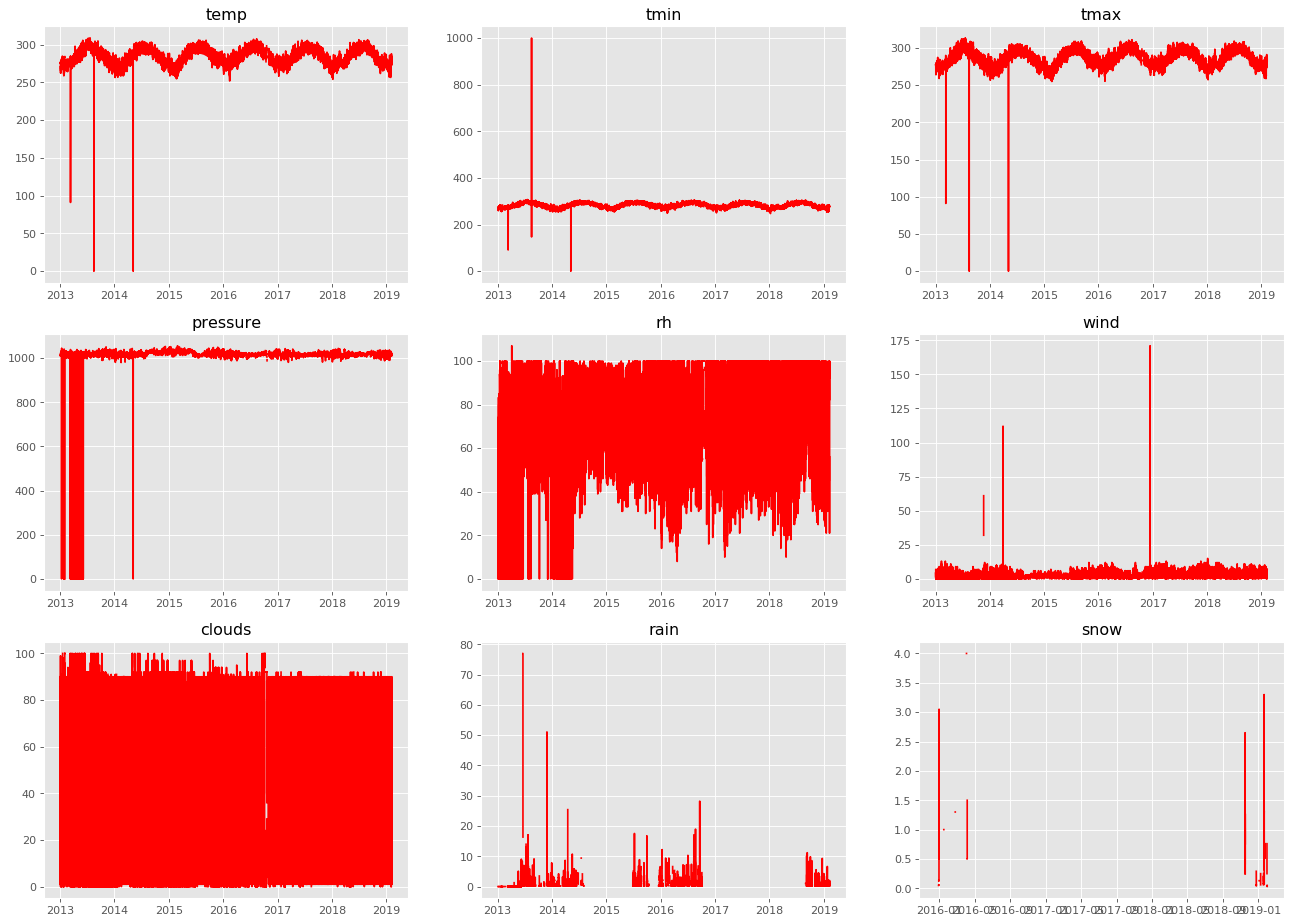

In [4]:
fn.plot_all(raw_weather,'2013-01-02 00:00:00','2019-02-09 00:00:00')
# print(raw_weather.isnull().sum())

## Error Identification
For this weather data, manual high and low "tuner" values are implemented to remove errors

In [5]:
# set violating values to NaN based on hardcoded low and high limit values for each column separately
sparse_weather = raw_weather.copy(deep=True)

low_tuners = [250,240,250,900,5,0,0,0,0]
high_tuners = [350,350,350,1100,100,25,100,100,10]
j=0

for i in raw_weather.columns:
    sparse_weather[i].where(sparse_weather[i] >= low_tuners[j],inplace=True)
    sparse_weather[i].where(sparse_weather[i] <= high_tuners[j],inplace=True)
    j=j+1

In [6]:
# assign NaN precip values to zero, this is an unconfirmed assumption
sparse_weather['rain'].replace(np.NaN,0,inplace=True)
sparse_weather['snow'].replace(np.NaN,0,inplace=True)

# set initial humidity value to suppress errors
sparse_weather['rh'][0] = 46

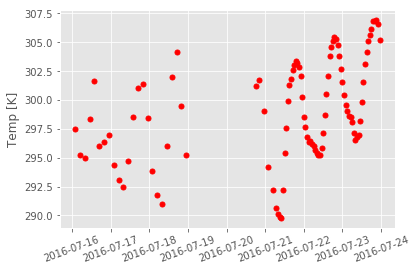

In [7]:
fn.plot_feature(sparse_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
# print(sparse_weather.isnull().sum())

## Imputation
Gaps shorter than 6 hours are filled using linear interpolation. Gaps longer than 6 hours are filled by fitting a least-squares optimized sine curve to the week of data prior to the gap, then extrapolating that curve through the gap.

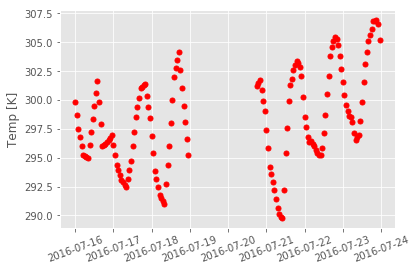

In [8]:
# impute missing ranges shorter than 6 hours using linear interpolation
dense_weather = sparse_weather.copy(deep=True)

# interpolate gaps in consumption data 6 hours and shorter
for k in dense_weather.columns:
    dense_weather[k] = fn.limited_impute(dense_weather[k],6)

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')
# print(dense_weather.isnull().sum())

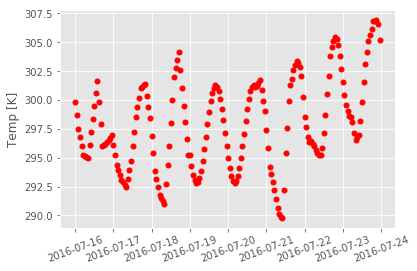

In [9]:
# sinusoidal imputation for gaps longer than 6 hours
for k in dense_weather.columns:
    
    # find gap locations and lengths
    series = dense_weather[k].copy(deep=True)
    gaps = fn.gaps(series)
    
    # iterate through list of gaps and fill each one using the week of data prior to the gap
    for i in gaps.index:  
        fit_data = series[gaps.start_int[i] - 24*7:gaps.start_int[i]]

        # first try sinusoidal imputation, then resort to median filling
        try:
            fit = fn.sine_fit(np.arange(len(fit_data)),fit_data.values)
            imputed_values = fit['fit'](np.arange(len(fit_data)+1,len(fit_data)+gaps.length[i]+1))
        except:
            imputed_values = np.full(gaps.length[i],np.median(fit_data.values))

        # replace the gap with the imputed values
        series[gaps.start_int[i]:gaps.end_int[i]] = imputed_values
        
    dense_weather[k] = series

fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')

## Preparation for export
For now, only temperature and relative humidity lag features are being considered for the predictive models. This cell removes other columns and adds the lag variables.

In [10]:
export = dense_weather.iloc[:,[0,4]].round(2)
for k in export.columns:
    for i in range(1,7):
        export[k+' -'+str(i)] = np.append(np.array([np.nan]*i),export[k].values[0:len(export)-i])

In [11]:
export.to_csv('../data/weather_clean.csv')

### unused code below

In [12]:
# # returns index labels where nan values appear for a certain column
# nan_index = weather['temp'].index[weather['temp'].apply(np.isnan)]
# nan_index

# correct and complete datetime index for the date range considered
# dt = pd.DatetimeIndex(start='2013-01-01 00:00:00',end='2019-02-10 00:00:00',freq='h')

# # renames (here, makes lowercase) column labels using a simple loop
# df.columns = [x.lower() for x in df.columns]

# # implements sklearn scaler
# from sklearn import preprocessing
# x = df.values #returns a numpy array
# scaler = preprocessing.MinMaxScaler()
# x_scaled = scaler.fit_transform(x)
# df = pandas.DataFrame(x_scaled)

In [13]:
# COULD BE USEFUL, first implementation of fit_sin that worked pretty well

# # assigning gap indices manually for now, use impute_ok later on
# gap_start = dense_weather.index.get_loc('2016-07-19 00:00:00')
# gap_end = dense_weather.index.get_loc('2016-07-20 17:00:00')
# gap_length = gap_end - gap_start

# # could calculate this as gap_start - (gap_length*2,3)
# impute_start = dense_weather.index.get_loc('2016-07-10 00:00:00')

# # subset dense_weather to the values just before the gap
# impute_data = dense_weather.iloc[impute_start:gap_start]
# impute_data.index = np.arange(len(impute_data))

# fit = fn.fit_sin(impute_data.index,impute_data['temp'])

# dense_weather.iloc[gap_start:gap_end,[0]] = pd.DataFrame(fit['fitfunc'](np.arange(len(impute_data),len(impute_data)+gap_length,1))).values

# fn.plot_feature(dense_weather,'temp','2016-07-16 00:00:00','2016-07-24 00:00:00',ylabel='Temp [K]')

# impute_data['temp'].values
# impute_data.iloc[:,[0]].T.values
